# Stroke Classification

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.preprocessing import PowerTransformer, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix
from sklearn.semi_supervised import LabelPropagation

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

# Functions

In [3]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()

# EDA Analysis

In [2]:
df = pd.read_csv("/Users/maukanmir/Downloads/data.csv", nrows=50000)
df

,ID,Age,Gender,Hypertension,Heart Disease,Ever Married,Work Type,Residence Type,Average Glucose Level,BMI,...,Dietary Habits,Alcohol Consumption,Chronic Stress,Sleep Hours,Family History of Stroke,Education Level,Income Level,Stroke Risk Score,Region,Stroke Occurrence
0,1,78,Female,0,0,1,Private,Rural,267.30,36.2,...,Non-Vegetarian,0,0,11,0,Tertiary,Middle,88,South,0
1,2,60,Female,0,0,0,Private,Rural,207.24,19.8,...,Vegetarian,0,0,9,0,Secondary,High,56,East,0
2,3,69,Male,0,0,0,Private,Urban,161.30,34.5,...,Mixed,1,0,3,0,Secondary,High,63,North,1
3,4,43,Male,0,0,1,Never Worked,Urban,247.49,48.8,...,Mixed,0,1,4,0,Tertiary,Middle,93,South,0
4,5,30,Female,0,0,1,Government,Urban,116.57,31.3,...,Mixed,0,1,9,0,Secondary,High,99,West,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49996,25,Female,0,0,0,Private,Urban,224.16,18.8,...,Non-Vegetarian,0,0,9,0,Primary,Low,40,West,0
49996,49997,31,Female,0,0,0,Never Worked,Rural,182.97,39.9,...,Non-Vegetarian,0,0,10,0,Secondary,High,40,West,0
49997,49998,58,Female,0,0,0,Children,Urban,82.91,19.4,...,Vegetarian,0,0,6,0,Secondary,Middle,42,North,0
49998,49999,62,Female,0,0,0,Never Worked,Rural,283.60,48.9,...,Non-Vegetarian,1,0,5,0,No education,High,79,East,0


# Check Nulls Dupes

In [4]:
check_for_nulls_dupes(df)

The amount of Null Values: ID                          0
Age                         0
Gender                      0
Hypertension                0
Heart Disease               0
Ever Married                0
Work Type                   0
Residence Type              0
Average Glucose Level       0
BMI                         0
Smoking Status              0
Physical Activity           0
Dietary Habits              0
Alcohol Consumption         0
Chronic Stress              0
Sleep Hours                 0
Family History of Stroke    0
Education Level             0
Income Level                0
Stroke Risk Score           0
Region                      0
Stroke Occurrence           0
dtype: int64
The amount of Duplicated Values 0


# Check Class Imbalance

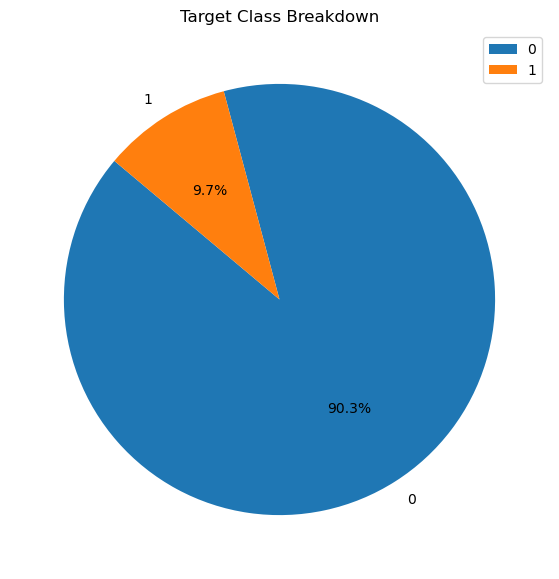

In [6]:
check_class_imbalance(df["Stroke Occurrence"])

# Severe Class Imabalnce Exists

In [7]:
df.dtypes

ID                            int64
Age                           int64
Gender                       object
Hypertension                  int64
Heart Disease                 int64
Ever Married                  int64
Work Type                    object
Residence Type               object
Average Glucose Level       float64
BMI                         float64
Smoking Status               object
Physical Activity            object
Dietary Habits               object
Alcohol Consumption           int64
Chronic Stress                int64
Sleep Hours                   int64
Family History of Stroke      int64
Education Level              object
Income Level                 object
Stroke Risk Score             int64
Region                       object
Stroke Occurrence             int64
dtype: object

In [8]:
df.describe()

,ID,Age,Hypertension,Heart Disease,Ever Married,Average Glucose Level,BMI,Alcohol Consumption,Chronic Stress,Sleep Hours,Family History of Stroke,Stroke Risk Score,Stroke Occurrence
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,25000.500000,53.911180,0.14832,0.099920,0.298560,184.903911,30.077362,0.200140,0.250440,7.495380,0.150000,50.557060,0.097260
std,14433.901067,21.069816,0.35542,0.299896,0.457631,66.343691,11.564942,0.400109,0.433271,2.869025,0.357075,28.909801,0.296314
min,1.000000,18.000000,0.00000,0.000000,0.000000,70.000000,10.000000,0.000000,0.000000,3.000000,0.000000,1.000000,0.000000
25%,12500.750000,36.000000,0.00000,0.000000,0.000000,127.347500,20.100000,0.000000,0.000000,5.000000,0.000000,26.000000,0.000000
50%,25000.500000,54.000000,0.00000,0.000000,0.000000,184.785000,30.100000,0.000000,0.000000,7.000000,0.000000,51.000000,0.000000
75%,37500.250000,72.000000,0.00000,0.000000,1.000000,242.140000,40.100000,0.000000,1.000000,10.000000,0.000000,76.000000,0.000000
max,50000.000000,90.000000,1.00000,1.000000,1.000000,300.000000,50.000000,1.000000,1.000000,12.000000,1.000000,100.000000,1.000000


In [9]:
df

,ID,Age,Gender,Hypertension,Heart Disease,Ever Married,Work Type,Residence Type,Average Glucose Level,BMI,...,Dietary Habits,Alcohol Consumption,Chronic Stress,Sleep Hours,Family History of Stroke,Education Level,Income Level,Stroke Risk Score,Region,Stroke Occurrence
0,1,78,Female,0,0,1,Private,Rural,267.30,36.2,...,Non-Vegetarian,0,0,11,0,Tertiary,Middle,88,South,0
1,2,60,Female,0,0,0,Private,Rural,207.24,19.8,...,Vegetarian,0,0,9,0,Secondary,High,56,East,0
2,3,69,Male,0,0,0,Private,Urban,161.30,34.5,...,Mixed,1,0,3,0,Secondary,High,63,North,1
3,4,43,Male,0,0,1,Never Worked,Urban,247.49,48.8,...,Mixed,0,1,4,0,Tertiary,Middle,93,South,0
4,5,30,Female,0,0,1,Government,Urban,116.57,31.3,...,Mixed,0,1,9,0,Secondary,High,99,West,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49996,25,Female,0,0,0,Private,Urban,224.16,18.8,...,Non-Vegetarian,0,0,9,0,Primary,Low,40,West,0
49996,49997,31,Female,0,0,0,Never Worked,Rural,182.97,39.9,...,Non-Vegetarian,0,0,10,0,Secondary,High,40,West,0
49997,49998,58,Female,0,0,0,Children,Urban,82.91,19.4,...,Vegetarian,0,0,6,0,Secondary,Middle,42,North,0
49998,49999,62,Female,0,0,0,Never Worked,Rural,283.60,48.9,...,Non-Vegetarian,1,0,5,0,No education,High,79,East,0
